### Pre-processing and combining dfs ###

In [25]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, box, LineString
import seaborn as sns

# For a single participant (with plots)

In [3]:
# Get participant number input
participant_number = input("Enter participant number: ")

# Define the base path
base_path = "/Users/alina/Downloads/Thesis/raw/"

# Build the folder path for the participant
folder_path = os.path.join(base_path, f"Participant {participant_number}")

# Get recording number input
recording_number = input("Enter recording number: ")

# Build the recording folder path
recording_path = os.path.join(folder_path, f"P{participant_number}_{recording_number}")

# Read the CSV files with dynamic paths
events_file = os.path.join(recording_path, f"events.csv")
face_detections_file =  os.path.join(recording_path, "face_detections.csv")
fixations_file = os.path.join(recording_path, "fixations.csv")
face_file = os.path.join(recording_path, "fixations_on_face.csv")

# Load the data
events_df = pd.read_csv(events_file)
face_detections_df = pd.read_csv(face_detections_file)
fixations_df = pd.read_csv(fixations_file)
face_df = pd.read_csv(face_file)

## function_1 for leaving only experiment-relevant data

def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
    """
    Filters a DataFrame to include only rows where the timestamp falls within any given intervals.

    Parameters:
        df: The DataFrame to filter.
        intervals (list of tuple): List of (start_time, end_time) pairs.
        timestamp_col (str): Name of the timestamp column.

    Returns:
        pd.DataFrame: Filtered DataFrame with rows in any of the intervals.
    """
    filter = pd.Series(False, index=df.index)  # start with all False

    for start, end in intervals:
        filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

    return df[filter]

## to filter each file by leaving only experiment timestamps

events_df = events_df.sort_values("timestamp [ns]")

# Filter for events where name == 'A'
A_events = events_df[events_df["name"] == "A"]
B_events = events_df[events_df["name"] == "B"]
C_events = events_df[events_df["name"] == "C"]
D_events = events_df[events_df["name"] == "D"]

# Get the highest (except D) and lowest (except A) timestamp from that filtered DataFrame
max_timestamp_A = A_events["timestamp [ns]"].max()
min_timestamp_B = B_events["timestamp [ns]"].min()

max_timestamp_B = B_events["timestamp [ns]"].max()
min_timestamp_C = C_events["timestamp [ns]"].min()

max_timestamp_C = C_events["timestamp [ns]"].max()
min_timestamp_D = D_events["timestamp [ns]"].min()

# intervals to use for filter_by_intervals function
intervals = [
    (max_timestamp_A, min_timestamp_B),
    (max_timestamp_B, min_timestamp_C),
    (max_timestamp_C, min_timestamp_D)
]

In [4]:
face_detections_df = filter_by_intervals(face_detections_df, intervals, timestamp_col='timestamp [ns]')
fixations_df = filter_by_intervals(fixations_df, intervals, timestamp_col='start timestamp [ns]')
face_df = filter_by_intervals(face_df, intervals, timestamp_col='start timestamp [ns]')

#
face_with_coordinates_df = pd.merge(
    fixations_df,
    face_df,
    on="start timestamp [ns]",
    how="inner"  # or "left" if you want to keep all fixations and NaNs for unmatched
)

# leave only fixations on face
face_with_coordinates_df = face_with_coordinates_df[face_with_coordinates_df['fixation on face'] == True]

#face_with_coordinates_df.head()
#print(len(face_with_coordinates_df))


In [5]:
matched_rows = []
unmatched_fixations = 0

# Make sure timestamps are integers
face_detections_df['timestamp [ns]'] = face_detections_df['timestamp [ns]'].astype(int)

# Get sorted unique timestamps
unique_timestamps = face_detections_df['timestamp [ns]'].sort_values().unique()

for i, fixation_row in face_with_coordinates_df.iterrows():
    ts_start = fixation_row['start timestamp [ns]']
    ts_end = fixation_row['end timestamp [ns]_x']
    fx = fixation_row['fixation x [px]']
    fy = fixation_row['fixation y [px]']

    timestamps_in_interval = unique_timestamps[(unique_timestamps >= ts_start) & (unique_timestamps <= ts_end)]
    
    found = False
    for ts in timestamps_in_interval:
        detections_at_ts = face_detections_df[face_detections_df['timestamp [ns]'] == ts]
        
        for _, det_row in detections_at_ts.iterrows():
            x1 = det_row['p1 x [px]']
            y1 = det_row['p1 y [px]']
            x2 = det_row['p2 x [px]']
            y2 = det_row['p2 y [px]']

            if x1 <= fx <= x2 and y1 <= fy <= y2:
                combined = {**fixation_row.to_dict(), **det_row.to_dict()}
                matched_rows.append(combined)
                found = True
                break  # Only first match at this timestamp

        if found:
            break  # Stop checking further timestamps once matched

    if not found:
        unmatched_fixations += 1

print(f"Total fixations: {len(face_with_coordinates_df)}")
print(f"Matched fixations: {len(matched_rows)}")
print(f"Unmatched fixations: {unmatched_fixations}")

matched_df = pd.DataFrame(matched_rows)


Total fixations: 226
Matched fixations: 208
Unmatched fixations: 18


#### To check if unmatched fixations fall into a bounding box ####

In [11]:
### if i want to illustrate all

"""for _, row in matched_df.iterrows():
    ts_start = row['start timestamp [ns]']
    ts_end = row['end timestamp [ns]_x']
    fx, fy = row['fixation x [px]'], row['fixation y [px]']

    candidates = face_detections_df[
        (face_detections_df['timestamp [ns]'] >= ts_start) &
        (face_detections_df['timestamp [ns]'] <= ts_end)
    ]

    plt.figure(figsize=(8, 6))
    for _, det in candidates.iterrows():
        x1, y1 = det['p1 x [px]'], det['p1 y [px]']
        x2, y2 = det['p2 x [px]'], det['p2 y [px]']
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue'))
    plt.plot(fx, fy, 'ro')  # fixation point
    plt.title(f"Fixation at timestamp: {ts_start}–{ts_end}")
    plt.gca().invert_yaxis()
    plt.show()"""


'for _, row in matched_df.iterrows():\n    ts_start = row[\'start timestamp [ns]\']\n    ts_end = row[\'end timestamp [ns]_x\']\n    fx, fy = row[\'fixation x [px]\'], row[\'fixation y [px]\']\n\n    candidates = face_detections_df[\n        (face_detections_df[\'timestamp [ns]\'] >= ts_start) &\n        (face_detections_df[\'timestamp [ns]\'] <= ts_end)\n    ]\n\n    plt.figure(figsize=(8, 6))\n    for _, det in candidates.iterrows():\n        x1, y1 = det[\'p1 x [px]\'], det[\'p1 y [px]\']\n        x2, y2 = det[\'p2 x [px]\'], det[\'p2 y [px]\']\n        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=\'blue\'))\n    plt.plot(fx, fy, \'ro\')  # fixation point\n    plt.title(f"Fixation at timestamp: {ts_start}–{ts_end}")\n    plt.gca().invert_yaxis()\n    plt.show()'

In [ ]:
# Get unmatched fixation IDs
all_fixation_ids = set(face_with_coordinates_df['fixation id_x'])
matched_fixation_ids = set(matched_df['fixation id_x'])

unmatched_ids = list(all_fixation_ids - matched_fixation_ids)
print(f"Fixation IDs unmatched: {len(unmatched_ids)}")

# For each unmatched fixation, check whether the fixation falls inside any face bbox during its interval
check_results = []

for fid in unmatched_ids:
    fixation_row = face_with_coordinates_df[face_with_coordinates_df['fixation id_x'] == fid].iloc[0]

    ts_start = fixation_row['start timestamp [ns]']
    ts_end = fixation_row['end timestamp [ns]_x']
    fx = fixation_row['fixation x [px]']
    fy = fixation_row['fixation y [px]']

    detections = face_detections_df[
        (face_detections_df['timestamp [ns]'] >= ts_start) &
        (face_detections_df['timestamp [ns]'] <= ts_end)
    ]

    matched = False
    for _, det in detections.iterrows():
        x1, y1 = det['p1 x [px]'], det['p1 y [px]']
        x2, y2 = det['p2 x [px]'], det['p2 y [px]']

        # Ensure proper box orientation
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)

        if x1 <= fx <= x2 and y1 <= fy <= y2:
            matched = True
            break

    check_results.append({
        'fixation id': fid,
        'start timestamp [ns]': ts_start,
        'end timestamp [ns]_x': ts_end,
        'fixation x [px]': fx,
        'fixation y [px]': fy,
        'falls_in_any_bbox': matched
    })

#  Create a summary DataFrame
unmatched_check_df = pd.DataFrame(check_results)
print(unmatched_check_df['falls_in_any_bbox'].value_counts())


Fixation IDs unmatched: 13
falls_in_any_bbox
False    13
Name: count, dtype: int64


In [ ]:
## to get a list of all unmatched fixations from the recording with their ts and ids
unmatched_check_df
#unmatched_check_df.to_csv('unmatched_fixation_bbox_check.csv', index=False)

,fixation id,start timestamp [ns],end timestamp [ns]_x,fixation x [px],fixation y [px],falls_in_any_bbox
0,3009,1743587311832408504,1743587312117658504,859.275,1079.457,False
1,6275,1743588562015043504,1743588562170170504,1278.684,373.863,False
2,3398,1743587478447438504,1743587478522560504,940.695,319.634,False
3,2599,1743587155491841504,1743587155812091504,489.665,461.972,False
4,5386,1743588238875379504,1743588239045507504,808.915,300.881,False
5,4941,1743588054839060504,1743588057481440504,794.566,1041.821,False
6,4142,1743587742508304504,1743587742658429504,871.323,420.498,False
7,5391,1743588240516885504,1743588241092381504,718.997,310.658,False
8,2926,1743587277060009504,1743587277605509504,1115.779,922.562,False
9,5298,1743588209357864504,1743588209773230504,822.512,300.530,False


In [14]:
## to ilustrate unmatched ones

"""#  Iterate through the unmatched fixations
for _, row in unmatched_check_df.iterrows():
    if row['falls_in_any_bbox'] == False:  # Only show unmatched fixations
        ts_start = row['start timestamp [ns]']
        ts_end = row['end timestamp [ns]_x']
        fx, fy = row['fixation x [px]'], row['fixation y [px]']

        # Get all face detections within this timestamp range
        candidates = face_detections_df[
            (face_detections_df['timestamp [ns]'] >= ts_start) &
            (face_detections_df['timestamp [ns]'] <= ts_end)
        ]

       # Create a plot for each unmatched fixation
        plt.figure(figsize=(8, 6))
        for _, det in candidates.iterrows():
            x1, y1 = det['p1 x [px]'], det['p1 y [px]']
            x2, y2 = det['p2 x [px]'], det['p2 y [px]']
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue'))

        # Plot the fixation point (red dot)
        plt.plot(fx, fy, 'ro', label="Fixation")

        # Add title, invert y-axis for proper coordinate display
        plt.title(f"Unmatched Fixation\nTime: {ts_start}–{ts_end}")
        plt.gca().invert_yaxis()  # Invert Y-axis for image coordinates
        plt.legend()
        plt.show()
"""

'#  Iterate through the unmatched fixations\nfor _, row in unmatched_check_df.iterrows():\n    if row[\'falls_in_any_bbox\'] == False:  # Only show unmatched fixations\n        ts_start = row[\'start timestamp [ns]\']\n        ts_end = row[\'end timestamp [ns]_x\']\n        fx, fy = row[\'fixation x [px]\'], row[\'fixation y [px]\']\n\n        # Get all face detections within this timestamp range\n        candidates = face_detections_df[\n            (face_detections_df[\'timestamp [ns]\'] >= ts_start) &\n            (face_detections_df[\'timestamp [ns]\'] <= ts_end)\n        ]\n\n       # Create a plot for each unmatched fixation\n        plt.figure(figsize=(8, 6))\n        for _, det in candidates.iterrows():\n            x1, y1 = det[\'p1 x [px]\'], det[\'p1 y [px]\']\n            x2, y2 = det[\'p2 x [px]\'], det[\'p2 y [px]\']\n            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=\'blue\'))\n\n        # Plot the fixation point (red dot)\n 

### Voronoi method for face landmarks ###

This method determines on which fixation AOI is based on which AOI's centre point it is closest to.

In [ ]:
### functions ###

# there are already AOI centers for eyes and nose provided by FaceMapper

## to find mouth centre point

def mouth_centre(m_left_x, m_left_y, m_right_x, m_right_y):
    # Calculate the center of the mouth by averaging the x and y coordinates
    mouth_x = (m_left_x + m_right_x) / 2
    mouth_y = (m_left_y + m_right_y) / 2
    return mouth_x, mouth_y


## to assign aois based on voronoi method for each row

def which_aoi(fix_x, fix_y, aoi_centers):
    
    """ Assigns the fixation to the nearest AOI center using Euclidean distance. """

    min_dist = float('inf')
    closest_aoi = None

    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        dist = np.sqrt((fix_x - aoi_x)**2 + (fix_y - aoi_y)**2)
        if dist < min_dist:
            min_dist = dist
            closest_aoi = aoi_id

    return closest_aoi


## to illustrate the results

def plot_fixation_and_aois(fix_x, fix_y, aoi_centers, assigned_aoi):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Plot AOI centers
    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        ax.plot(aoi_x, aoi_y, 'o', label=aoi_id)
        ax.text(aoi_x + 5, aoi_y + 5, aoi_id, fontsize=9, color='black')

    # Plot fixation point
    ax.plot(fix_x, fix_y, 'rx', label='Fixation')
    ax.text(fix_x + 5, fix_y + 5, 'Fixation', color='red')

    # Draw a line from fixation to the assigned AOI
    if assigned_aoi in aoi_centers:
        aoi_x, aoi_y = aoi_centers[assigned_aoi]
        ax.plot([fix_x, aoi_x], [fix_y, aoi_y], 'r--', label='Assigned AOI link')

    ax.set_title('Voronoi-Based AOI Assignment')
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    ax.legend()
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()  # Invert y-axis as working with screen coords
    plt.grid(True)
    plt.show()


In [12]:
assigned_aois = []

for _, row in matched_df.iterrows():
    mouth_x, mouth_y = mouth_centre(
        row['mouth left x [px]'], row['mouth left y [px]'],
        row['mouth right x [px]'], row['mouth right y [px]']
    )
    
    aoi_centers = {
        'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
        'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
        'nose': (row['nose x [px]'], row['nose y [px]']),
        'mouth': (mouth_x, mouth_y)
    }

    assigned_aoi = which_aoi(row['fixation x [px]'], row['fixation y [px]'], aoi_centers)

    #plot_fixation_and_aois(row['fixation x [px]'], row['fixation y [px]'], aoi_centers, assigned_aoi)

    assigned_aois.append(assigned_aoi)

matched_df['assigned_aoi'] = assigned_aois


In [9]:
matched_df['assigned_aoi'].unique()

array(['mouth', 'left_eye', 'nose', 'right_eye'], dtype=object)

In [56]:
#matched_df.info()

In [1]:
#matched_df[15:30]

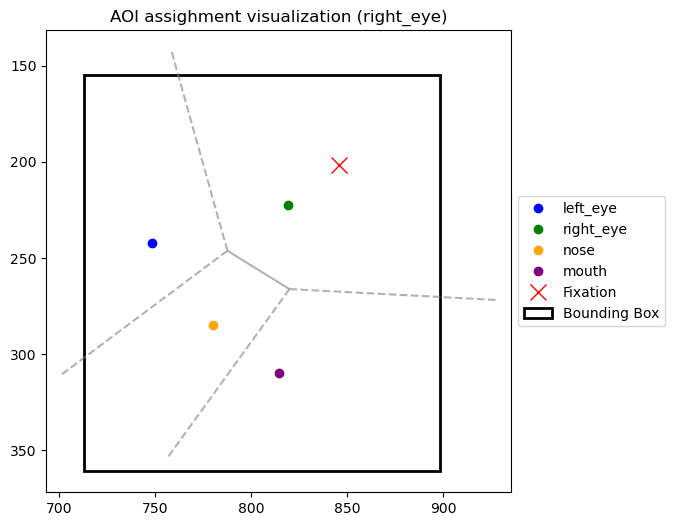

In [15]:
# Select the first row
row = matched_df.iloc[27]

# Calculate mouth center
mouth_x, mouth_y = mouth_centre(
    row['mouth left x [px]'], row['mouth left y [px]'],
    row['mouth right x [px]'], row['mouth right y [px]']
)

# Define AOI centers with colors
aoi_centers = {
    'left_eye': ((row['eye left x [px]'], row['eye left y [px]']), 'blue'),
    'right_eye': ((row['eye right x [px]'], row['eye right y [px]']), 'green'),
    'nose': ((row['nose x [px]'], row['nose y [px]']), 'orange'),
    'mouth': ((mouth_x, mouth_y), 'purple')
}

# Convert AOI coords to array for Voronoi
points = np.array([coords for coords, _ in aoi_centers.values()])

# Create Voronoi diagram
vor = Voronoi(points)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', line_width=1.5, line_alpha=0.6, point_size=0)

# Plot AOI points with different colors
for label, ((x, y), color) in aoi_centers.items():
    ax.plot(x, y, 'o', color=color, label=label)

# Plot fixation point
fix_x = row['fixation x [px]']
fix_y = row['fixation y [px]']
ax.plot(fix_x, fix_y, 'rx', markersize=12, label='Fixation')

# Draw bounding box from p1 (top-left) to p2 (bottom-right)
x1 = row['p1 x [px]']
y1 = row['p1 y [px]']
x2 = row['p2 x [px]']
y2 = row['p2 y [px]']
bbox_w = x2 - x1
bbox_h = y2 - y1
rect = plt.Rectangle((x1, y1), bbox_w, bbox_h, linewidth=2, edgecolor='black', facecolor='none', label='Bounding Box')
ax.add_patch(rect)

# Add legend outside plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set title and display
ax.set_title(f"AOI assighment visualization ({assigned_aois[27]})")
plt.gca().invert_yaxis()
plt.axis('equal')
#plt.tight_layout()
plt.show()


In [16]:
## to plot on the normal video size

"""fig, ax = plt.subplots(figsize=(20, 15))

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray',
                line_width=1.5, line_alpha=0.6, point_size=0)


# Plot AOIs
for label, ((x, y), color) in aoi_centers.items():
    ax.plot(x, y, 'o', color=color)
    ax.text(x + 10, y, label, fontsize=10, color=color)  # Label slightly offset

# Plot fixation
ax.plot(fix_x, fix_y, 'rx', markersize=12)
ax.text(fix_x + 10, fix_y, 'Fixation', fontsize=10, color='red')

# Bounding box
rect = plt.Rectangle((x1, y1), bbox_w, bbox_h, linewidth=2,
                     edgecolor='black', facecolor='none')
ax.add_patch(rect)
ax.text(x1, y1 - 10, 'Bounding Box', fontsize=10, color='black')

# Coordinate fix
ax.set_xlim(0, 1622)
ax.set_ylim(0, 1212)
ax.set_aspect('equal')
plt.gca().invert_yaxis()
plt.title(f"Voronoi AOIs with Fixation (Assigned AOI: {assigned_aois[1]})")
plt.subplots_adjust(right=0.85)
plt.show()
"""

'fig, ax = plt.subplots(figsize=(20, 15))\n\nvoronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors=\'gray\',\n                line_width=1.5, line_alpha=0.6, point_size=0)\n\n\n# Plot AOIs\nfor label, ((x, y), color) in aoi_centers.items():\n    ax.plot(x, y, \'o\', color=color)\n    ax.text(x + 10, y, label, fontsize=10, color=color)  # Label slightly offset\n\n# Plot fixation\nax.plot(fix_x, fix_y, \'rx\', markersize=12)\nax.text(fix_x + 10, fix_y, \'Fixation\', fontsize=10, color=\'red\')\n\n# Bounding box\nrect = plt.Rectangle((x1, y1), bbox_w, bbox_h, linewidth=2,\n                     edgecolor=\'black\', facecolor=\'none\')\nax.add_patch(rect)\nax.text(x1, y1 - 10, \'Bounding Box\', fontsize=10, color=\'black\')\n\n# Coordinate fix\nax.set_xlim(0, 1622)\nax.set_ylim(0, 1212)\nax.set_aspect(\'equal\')\nplt.gca().invert_yaxis()\nplt.title(f"Voronoi AOIs with Fixation (Assigned AOI: {assigned_aois[1]})")\nplt.subplots_adjust(right=0.85)\nplt.show()\n'

### Statistics ###

In [60]:
### leaving only needed columns

face_landmarks_df = matched_df[['fixation id_x', 'start timestamp [ns]', 'duration [ms]', 'assigned_aoi']]

face_landmarks_df.rename(columns={'fixation id_x': 'fixation id'})

face_landmarks_df.to_csv(os.path.join(recording_path, f"face_landmarks{participant_number}_{recording_number}.csv"))

In [65]:
face_landmarks_df
saving_path = os.path.join(recording_path, f"face_landmarks_{participant_number}_{recording_number}.csv")
face_landmarks_df.to_csv(saving_path, index=False)

assigned_aoi
right_eye    61
mouth        51
nose         49
left_eye     47
Name: count, dtype: int64


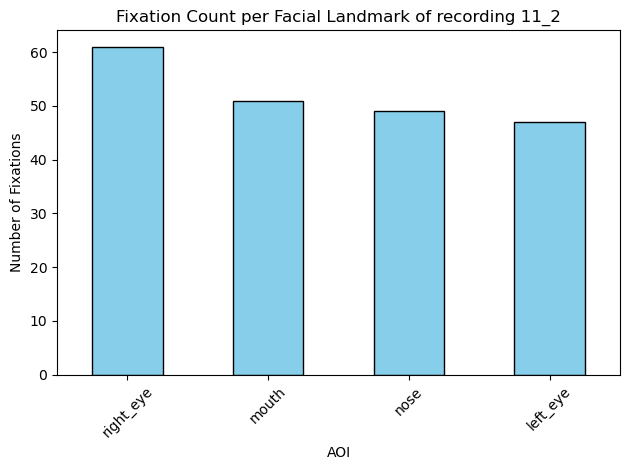

In [ ]:
# count each unique AOI assignment
aoi_counts = face_landmarks_df['assigned_aoi'].value_counts()

print(aoi_counts)

# histogram
aoi_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f'Fixation Count per Facial Landmark of recording {participant_number}_{recording_number}')
plt.xlabel('AOI')
plt.ylabel('Number of Fixations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For all participants

In [6]:
## to find mouth centre point

def mouth_centre(m_left_x, m_left_y, m_right_x, m_right_y):
    # Calculate the center of the mouth by averaging the x and y coordinates
    mouth_x = (m_left_x + m_right_x) / 2
    mouth_y = (m_left_y + m_right_y) / 2
    return mouth_x, mouth_y


## to assign aois based on voronoi method for each row

def which_aoi(fix_x, fix_y, aoi_centers):
    
    """ Assigns the fixation to the nearest AOI center using Euclidean distance. """

    min_dist = float('inf')
    closest_aoi = None

    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        dist = np.sqrt((fix_x - aoi_x)**2 + (fix_y - aoi_y)**2)
        if dist < min_dist:
            min_dist = dist
            closest_aoi = aoi_id

    return closest_aoi

## to determine of the face is side or full

def is_nose_outside_eyes(left_eye, right_eye, nose):
    return nose[0] < min(left_eye[0], right_eye[0]) or nose[0] > max(left_eye[0], right_eye[0])

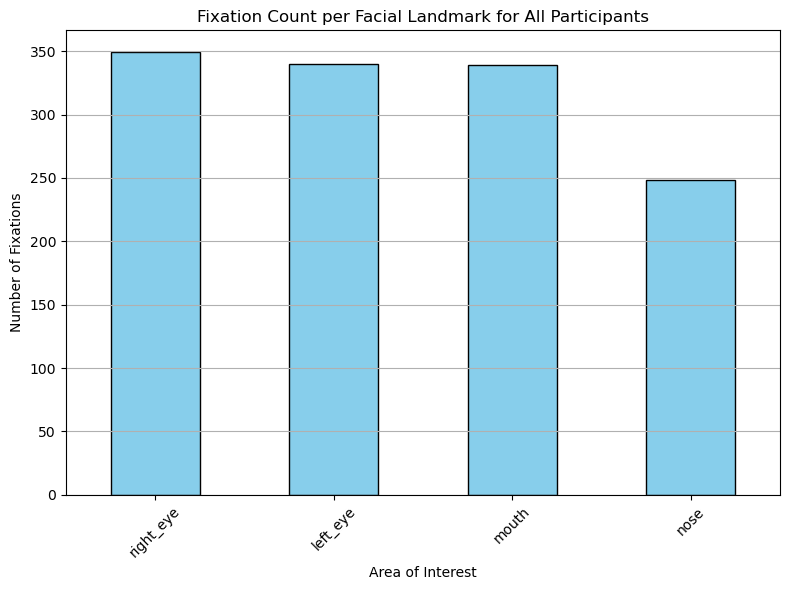

In [ ]:
### added side full face classification

base_path = "/Users/alina/Downloads/Thesis/raw/"

def process_recording(participant_number, recording_number, recording_path, result_df, aoi_assignments_df):
    try:
        # file paths
        events_file = os.path.join(recording_path, "events.csv")
        face_detections_file = os.path.join(recording_path, "face_detections.csv")
        fixations_file = os.path.join(recording_path, "fixations.csv")
        face_file = os.path.join(recording_path, "fixations_on_face.csv")

        # load all files
        events_df = pd.read_csv(events_file)
        face_detections_df = pd.read_csv(face_detections_file)
        fixations_df = pd.read_csv(fixations_file)
        face_df = pd.read_csv(face_file)

        def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
            filter = pd.Series(False, index=df.index)  # start with all False

            for start, end in intervals:
                filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

            return df[filter]

        ## to filter each file by leaving only experiment timestamps
        events_df = events_df.sort_values("timestamp [ns]")
        A_events = events_df[events_df["name"] == "A"]
        B_events = events_df[events_df["name"] == "B"]
        C_events = events_df[events_df["name"] == "C"]
        D_events = events_df[events_df["name"] == "D"]

        max_timestamp_A = A_events["timestamp [ns]"].max()
        min_timestamp_B = B_events["timestamp [ns]"].min()
        max_timestamp_B = B_events["timestamp [ns]"].max()
        min_timestamp_C = C_events["timestamp [ns]"].min()
        max_timestamp_C = C_events["timestamp [ns]"].max()
        min_timestamp_D = D_events["timestamp [ns]"].min()

        intervals = [
            (max_timestamp_A, min_timestamp_B),
            (max_timestamp_B, min_timestamp_C),
            (max_timestamp_C, min_timestamp_D)
        ]

        # Apply filtering
        face_detections_df = filter_by_intervals(face_detections_df, intervals, timestamp_col='timestamp [ns]')
        fixations_df = filter_by_intervals(fixations_df, intervals, timestamp_col='start timestamp [ns]')
        face_df = filter_by_intervals(face_df, intervals, timestamp_col='start timestamp [ns]')

        # Merge fixations on face
        face_with_coordinates_df = pd.merge(
            fixations_df,
            face_df,
            on="start timestamp [ns]",
            how="inner"
        )
        face_with_coordinates_df = face_with_coordinates_df[face_with_coordinates_df['fixation on face'] == True]

        # Matching fixations with detections
        matched_rows = []
        unmatched_fixations = 0
        face_detections_df['timestamp [ns]'] = face_detections_df['timestamp [ns]'].astype(int)
        unique_timestamps = face_detections_df['timestamp [ns]'].sort_values().unique()

        for _, fixation_row in face_with_coordinates_df.iterrows():
            ts_start = fixation_row['start timestamp [ns]']
            ts_end = fixation_row['end timestamp [ns]_x']
            fx = fixation_row['fixation x [px]']
            fy = fixation_row['fixation y [px]']

            timestamps_in_interval = unique_timestamps[(unique_timestamps >= ts_start) & (unique_timestamps <= ts_end)]

            found = False
            for ts in timestamps_in_interval:
                detections_at_ts = face_detections_df[face_detections_df['timestamp [ns]'] == ts]

                for _, det_row in detections_at_ts.iterrows():
                    x1, y1 = det_row['p1 x [px]'], det_row['p1 y [px]']
                    x2, y2 = det_row['p2 x [px]'], det_row['p2 y [px]']

                    if x1 <= fx <= x2 and y1 <= fy <= y2:
                        combined = {**fixation_row.to_dict(), **det_row.to_dict()}
                        matched_rows.append(combined)
                        found = True
                        break
                if found:
                    break

            if not found:
                unmatched_fixations += 1

        # AOI assignment
        matched_df = pd.DataFrame(matched_rows)
        assigned_aois = []
        fixation_ids = []
        start_timestamps = []
        durations = []
        side_faces = []
        full_faces = []

        for _, row in matched_df.iterrows():

            st_ts = row['start timestamp [ns]']
            fix_id = row['fixation id_x']
            duration = row['duration [ms]']

            mouth_x, mouth_y = mouth_centre(
                row['mouth left x [px]'], row['mouth left y [px]'],
                row['mouth right x [px]'], row['mouth right y [px]']
            )

            aoi_centers = {
                'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
                'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
                'nose': (row['nose x [px]'], row['nose y [px]']),
                'mouth': (mouth_x, mouth_y)
            }
            # for side & full face count
            left_eye = (row['eye left x [px]'], row['eye left y [px]'])
            right_eye = (row['eye right x [px]'], row['eye right y [px]'])
            nose = (row['nose x [px]'], row['nose y [px]'])
            side_face = is_nose_outside_eyes(left_eye, right_eye, nose)

            side_faces.append(side_face)
            full_faces.append(not side_face)

            assigned_aoi = which_aoi(row['fixation x [px]'], row['fixation y [px]'], aoi_centers)
            assigned_aois.append(assigned_aoi)
            start_timestamps.append(st_ts)
            fixation_ids.append(fix_id)
            durations.append(duration)

        # a df for the assigned face AOIs
        aoi_assignments_df = pd.concat([aoi_assignments_df, pd.DataFrame({
            'Participant': [participant_number] * len(assigned_aois),
            'Recording': [recording_number] * len(assigned_aois),
            'assigned_aoi': assigned_aois,
            'start timestamp [ns]': start_timestamps,
            'fixation_id': fixation_ids,
            'duration (ms)': durations
        })], ignore_index=True)


        # df on matched and umatched fixations
        result_df = pd.concat([result_df, pd.DataFrame([{
            'Participant': participant_number,
            'Recording': recording_number,
            'total_face_fixations': len(face_with_coordinates_df),
            'matched_fixations': len(matched_rows),
            'unmatched_fixations': unmatched_fixations,
            'side-faces fixations': sum(side_faces),
            'full-faces fixations': sum(full_faces)
        }])], ignore_index=True)

    except Exception as e:
        print(f"Error processing Participant {participant_number}, Recording {recording_number}: {e}")
    return result_df, aoi_assignments_df


# empty df to store the results later
results_df = pd.DataFrame(columns=['Participant', 'Recording', 'total_fixations', 'matched_fixations', 'unmatched_fixations'])

# empty df to store the face AOI assignments later
aoi_assignments_df = pd.DataFrame(columns=['Participant', 'Recording', 'start timestamp [ns]','fixation_id', 'assigned_aoi', 'duration (ms)'])

# scan all participants and recordings
for participant_folder in os.listdir(base_path):
    if participant_folder.startswith("Participant"):
        participant_number = participant_folder.split()[-1]
        folder_path = os.path.join(base_path, participant_folder)

        for recording_folder in os.listdir(folder_path):
            if recording_folder.startswith(f"P{participant_number}_"):
                recording_number = recording_folder.split("_")[-1]
                recording_path = os.path.join(folder_path, recording_folder)
                results_df, aoi_assignments_df = process_recording(participant_number, recording_number, recording_path, results_df, aoi_assignments_df)

# results_df.to_csv('results.csv', index=False)

# count number of fixations for each face AOI
aoi_counts = aoi_assignments_df['assigned_aoi'].value_counts()

# histogram for all participants
plt.figure(figsize=(8, 6))
aoi_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Fixation Count per Facial Landmark for All Participants')
plt.xlabel('Area of Interest')
plt.ylabel('Number of Fixations')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
results_df # also contains information on the amount of matched full and side faces

,Participant,Recording,total_fixations,matched_fixations,unmatched_fixations,side-faces fixations,full-faces fixations
0,09,2,140,124,16,18.0,106.0
1,09,1,226,208,18,19.0,189.0
2,22,2,121,113,8,13.0,100.0
3,22,1,47,38,9,7.0,31.0
4,14,2,59,49,10,9.0,40.0
5,14,1,58,45,13,3.0,42.0
6,12,1,139,126,13,1.0,125.0
7,12,2,47,42,5,11.0,31.0
8,15,1,77,68,9,11.0,57.0
9,15,2,88,70,18,14.0,56.0


In [ ]:
# Aggregate fixation counts per participant (sum across recordings)
agg_dict = {
    "side-faces fixations": "sum",
    "full-faces fixations": "sum",
    "matched_fixations": "sum"
}
per_participant = results_df.groupby('Participant').agg(agg_dict).reset_index()

# mean and std across participants for fixation counts
summary_df = per_participant[['side-faces fixations', 'full-faces fixations']].agg(['mean', 'std']).round(2)


display(summary_df)

,side-faces fixations,full-faces fixations
mean,17.36,98.64
std,11.19,78.53


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_46967/64973907.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_46967/64973907.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


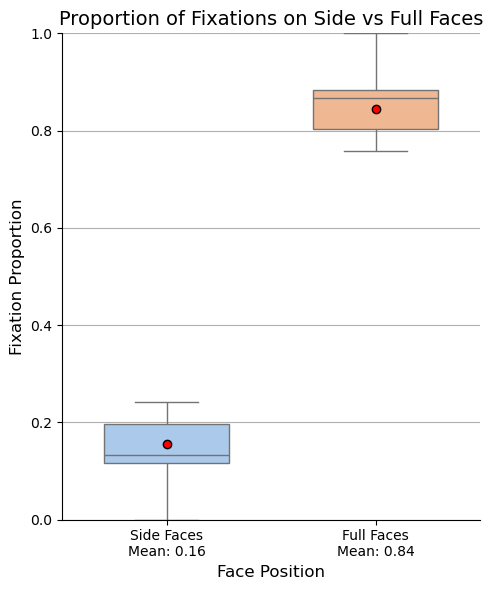

In [47]:

# Combine and compute proportions (same as before)
agg_dict = {
    "side-faces fixations": "sum",
    "full-faces fixations": "sum",
    "matched_fixations": "sum"
}
per_participant_results = results_df.groupby("Participant").agg(agg_dict).reset_index()
per_participant_results['side_prop'] = per_participant_results['side-faces fixations'] / per_participant_results['matched_fixations']
per_participant_results['full_prop'] = per_participant_results['full-faces fixations'] / per_participant_results['matched_fixations']

# Melt to long format
side_full_melted = per_participant_results.melt(
    id_vars=['Participant'],
    value_vars=['side_prop', 'full_prop'],
    var_name='Face Position',
    value_name='Fixation Proportion'
)

# Better labels
side_full_melted['Face Position'] = side_full_melted['Face Position'].map({
    'side_prop': 'Side Faces',
    'full_prop': 'Full Faces'
})

# Calculate means for display
group_means = side_full_melted.groupby('Face Position')['Fixation Proportion'].mean()
category_order = ['Side Faces', 'Full Faces']
new_labels = [f"{cat}\nMean: {group_means[cat]:.2f}" for cat in category_order]

# Plot boxplot (vertical layout)
plt.figure(figsize=(5, 6))
ax = sns.boxplot(
    data=side_full_melted,
    x='Face Position',
    y='Fixation Proportion',
    order=category_order,
    palette='pastel',
    showmeans=True,
    showfliers=False,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

# Set new x-axis labels with means
ax.set_xticklabels(new_labels)

# Add titles and labels
ax.set_title("Proportion of Fixations on Side vs Full Faces", fontsize=14)
ax.set_ylabel("Fixation Proportion", fontsize=12)
ax.set_xlabel("Face Position", fontsize=12)
ax.yaxis.grid(True)

sns.despine()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
# Compute summary stats: mean and standard deviation
summary_full_side_df = side_full_melted.groupby('Face Position')['Fixation Proportion'].agg(['mean', 'std']).round(2)

# Optional: Rename columns for clarity
summary_df = summary_df.rename(columns={
    'mean': 'Mean',
    'std': 'Standard Deviation'
})

# Display the summary DataFrame
display(summary_df)

,Mean,Standard Deviation
Face Position,,
Full Faces,0.844655,0.09
Side Faces,0.155345,0.09


### To filter for fixations where AOI size is not suitable to the ET resolution and do facial landmarks analysis

In [4]:
VORONOI_AREA_THRESHOLD = 826.15  # in px²

def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")  # <-- corrected to check for 2D
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

def compute_aoi_areas(aoi_centers, bbox_coords):
    points = np.array(list(aoi_centers.values()))
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    bbox = Polygon(bbox_coords)
    aoi_areas = {}
    for aoi_id, region in zip(aoi_centers.keys(), regions):
        polygon_points = vertices[region]
        poly = Polygon(polygon_points)
        poly_clipped = poly.intersection(bbox)
        aoi_areas[aoi_id] = poly_clipped.area
    return aoi_areas, vor, regions, vertices


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_46967/2743547419.py:136: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unassigned_aois_df = pd.concat([unassigned_aois_df, pd.DataFrame([{


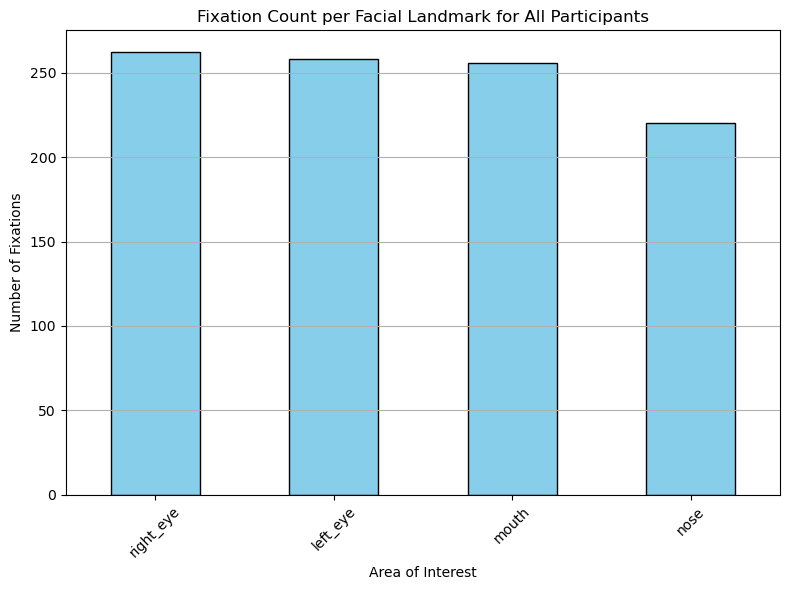

Number of assigned fixations: 996
Number of unassigned fixations: 1642


In [5]:
base_path = "/Users/alina/Downloads/Thesis/raw/"

def process_recording(participant_number, recording_number, recording_path, result_df, aoi_assignments_df, unassigned_aois_df):
    try:
        # file paths
        events_file = os.path.join(recording_path, "events.csv")
        face_detections_file = os.path.join(recording_path, "face_detections.csv")
        fixations_file = os.path.join(recording_path, "fixations.csv")
        face_file = os.path.join(recording_path, "fixations_on_face.csv")

        # load all files
        events_df = pd.read_csv(events_file)
        face_detections_df = pd.read_csv(face_detections_file)
        fixations_df = pd.read_csv(fixations_file)
        face_df = pd.read_csv(face_file)

        def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
            filter = pd.Series(False, index=df.index)  # start with all False

            for start, end in intervals:
                filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

            return df[filter]

        ## to filter each file by leaving only experiment timestamps
        events_df = events_df.sort_values("timestamp [ns]")
        A_events = events_df[events_df["name"] == "A"]
        B_events = events_df[events_df["name"] == "B"]
        C_events = events_df[events_df["name"] == "C"]
        D_events = events_df[events_df["name"] == "D"]

        max_timestamp_A = A_events["timestamp [ns]"].max()
        min_timestamp_B = B_events["timestamp [ns]"].min()
        max_timestamp_B = B_events["timestamp [ns]"].max()
        min_timestamp_C = C_events["timestamp [ns]"].min()
        max_timestamp_C = C_events["timestamp [ns]"].max()
        min_timestamp_D = D_events["timestamp [ns]"].min()

        intervals = [
            (max_timestamp_A, min_timestamp_B),
            (max_timestamp_B, min_timestamp_C),
            (max_timestamp_C, min_timestamp_D)
        ]

        # Apply filtering
        face_detections_df = filter_by_intervals(face_detections_df, intervals, timestamp_col='timestamp [ns]')
        fixations_df = filter_by_intervals(fixations_df, intervals, timestamp_col='start timestamp [ns]')
        face_df = filter_by_intervals(face_df, intervals, timestamp_col='start timestamp [ns]')

        # Merge fixations on face
        face_with_coordinates_df = pd.merge(
            fixations_df,
            face_df,
            on="start timestamp [ns]",
            how="inner"
        )
        face_with_coordinates_df = face_with_coordinates_df[face_with_coordinates_df['fixation on face'] == True]

        # Matching fixations with detections
        matched_rows = []
        unmatched_fixations = 0
        face_detections_df['timestamp [ns]'] = face_detections_df['timestamp [ns]'].astype(int)
        unique_timestamps = face_detections_df['timestamp [ns]'].sort_values().unique()

        for _, fixation_row in face_with_coordinates_df.iterrows():
            ts_start = fixation_row['start timestamp [ns]']
            ts_end = fixation_row['end timestamp [ns]_x']
            fx = fixation_row['fixation x [px]']
            fy = fixation_row['fixation y [px]']

            timestamps_in_interval = unique_timestamps[(unique_timestamps >= ts_start) & (unique_timestamps <= ts_end)]

            found = False
            for ts in timestamps_in_interval:
                detections_at_ts = face_detections_df[face_detections_df['timestamp [ns]'] == ts]

                for _, det_row in detections_at_ts.iterrows():
                    x1, y1 = det_row['p1 x [px]'], det_row['p1 y [px]']
                    x2, y2 = det_row['p2 x [px]'], det_row['p2 y [px]']

                    if x1 <= fx <= x2 and y1 <= fy <= y2:
                        combined = {**fixation_row.to_dict(), **det_row.to_dict()}
                        matched_rows.append(combined)
                        found = True
                        break
                if found:
                    break

            if not found:
                unmatched_fixations += 1

        # AOI assignment
        matched_df = pd.DataFrame(matched_rows)
        assigned_aois = []
        fixation_ids = []
        start_timestamps = []
        durations = []
        unassigned_aois_too_small = []

        for _, row in matched_df.iterrows():

            st_ts = row['start timestamp [ns]']
            fix_id = row['fixation id_x']
            duration = row['duration [ms]']

            mouth_x, mouth_y = mouth_centre(
                row['mouth left x [px]'], row['mouth left y [px]'],
                row['mouth right x [px]'], row['mouth right y [px]']
            )

            aoi_centers = {
                'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
                'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
                'nose': (row['nose x [px]'], row['nose y [px]']),
                'mouth': (mouth_x, mouth_y)
            }

            # Bounding box for this detection
            x1, y1 = row['p1 x [px]'], row['p1 y [px]']
            x2, y2 = row['p2 x [px]'], row['p2 y [px]']
            bbox_coords = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]

            # Compute AOI areas for this bounding box
            aoi_areas, _, _, _ = compute_aoi_areas(aoi_centers, bbox_coords)

            # Only process AOIs with area above threshold
            valid_aoi_centers = {k: v for k, v in aoi_centers.items() if aoi_areas.get(k, 0) > VORONOI_AREA_THRESHOLD}

            """for k, v in aoi_centers.items():
                if aoi_areas.get(k, 0) <= VORONOI_AREA_THRESHOLD:
                    unassigned_aois_too_small.append({'AOI': k, 'Area': aoi_areas.get(k, 0)})"""
            
            for k, v in aoi_centers.items():
                area = aoi_areas.get(k, 0)
                if area <= VORONOI_AREA_THRESHOLD:
                    unassigned_aois_df = pd.concat([unassigned_aois_df, pd.DataFrame([{
                      'Participant': participant_number,
                      'Recording': recording_number,
                      'assigned_aoi': k,
                      'aoi_area': area
                       }])], ignore_index=True)

            if not valid_aoi_centers:
                continue  # Skip this fixation if no AOI is large enough

            assigned_aoi = which_aoi(row['fixation x [px]'], row['fixation y [px]'], valid_aoi_centers)
            assigned_aois.append(assigned_aoi)
            start_timestamps.append(st_ts)
            fixation_ids.append(fix_id)
            durations.append(duration)

        # a df for the assigned face AOIs
        aoi_assignments_df = pd.concat([aoi_assignments_df, pd.DataFrame({
            'Participant': [participant_number] * len(assigned_aois),
            'Recording': [recording_number] * len(assigned_aois),
            'assigned_aoi': assigned_aois,
            'start timestamp [ns]': start_timestamps,
            'fixation_id': fixation_ids,
            'duration (ms)': durations
        })], ignore_index=True)


        # df on matched and umatched fixations
        result_df = pd.concat([result_df, pd.DataFrame([{
            'Participant': participant_number,
            'Recording': recording_number,
            'total_fixations': len(face_with_coordinates_df),
            'matched_fixations': len(matched_rows),
            'unmatched_fixations': unmatched_fixations
        }])], ignore_index=True)

    except Exception as e:
        print(f"Error processing Participant {participant_number}, Recording {recording_number}: {e}")
    return result_df, aoi_assignments_df, unassigned_aois_df

# empty df to store the results later
results_df = pd.DataFrame(columns=['Participant', 'Recording', 'total_fixations', 'matched_fixations', 'unmatched_fixations'])

# empty df to store the face AOI assignments later
aoi_assignments_df = pd.DataFrame(columns=['Participant', 'Recording', 'start timestamp [ns]','fixation_id', 'assigned_aoi', 'duration (ms)'])

unassigned_aois_df = pd.DataFrame(columns=['Participant', 'Recording', 'assigned_aoi', 'aoi_area'])

# scan all participants and recordings
for participant_folder in os.listdir(base_path):
    if participant_folder.startswith("Participant"):
        participant_number = participant_folder.split()[-1]
        folder_path = os.path.join(base_path, participant_folder)

        for recording_folder in os.listdir(folder_path):
            if recording_folder.startswith(f"P{participant_number}_"):
                recording_number = recording_folder.split("_")[-1]
                recording_path = os.path.join(folder_path, recording_folder)
                results_df, aoi_assignments_df, unassigned_aois_df = process_recording(participant_number, recording_number, recording_path, results_df, aoi_assignments_df, unassigned_aois_df)

# results_df.to_csv('results.csv', index=False)

# count number of fixations for each face AOI
aoi_counts = aoi_assignments_df['assigned_aoi'].value_counts()

# histogram for all participants
plt.figure(figsize=(8, 6))
aoi_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Fixation Count per Facial Landmark for All Participants')
plt.xlabel('Area of Interest')
plt.ylabel('Number of Fixations')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


num_assigned = len(aoi_assignments_df)
print(f"Number of assigned fixations: {num_assigned}")

num_unassigned_fixations = (len(unassigned_aois_df))
print(f"Number of unassigned fixations: {num_unassigned_fixations}")


In [8]:
results_df

,Participant,Recording,total_fixations,matched_fixations,unmatched_fixations
0,09,2,140,124,16
1,09,1,226,208,18
2,14,2,59,49,10
3,14,1,58,45,13
4,12,1,139,126,13
5,12,2,47,42,5
6,15,1,77,68,9
7,15,2,88,70,18
8,19,1,19,14,5
9,10,2,3,2,1


In [10]:
unassigned_aois_df

,Participant,Recording,assigned_aoi,aoi_area
0,09,2,right_eye,797.277994
1,09,2,nose,286.748005
2,09,2,left_eye,521.281520
3,09,2,nose,117.237298
4,09,2,mouth,550.454906
...,...,...,...,...
1071,20,2,mouth,183.745300
1072,20,2,left_eye,74.474365
1073,20,2,right_eye,120.237322
1074,20,2,nose,36.610381


In [9]:
aoi_assignments_df #sort for participant and recording number

,Participant,Recording,start timestamp [ns],fixation_id,assigned_aoi,duration (ms)
0,09,2,1742396388168520066,299,mouth,215
1,09,2,1742396455526286066,466,right_eye,245
2,09,2,1742396723775865066,1220,right_eye,260
3,09,2,1742396736837996066,1251,right_eye,80
4,09,2,1742396737243374066,1253,right_eye,220
...,...,...,...,...,...,...
819,20,2,1749035720137322116,4214,mouth,170
820,20,2,1749035720522697116,4216,nose,490
821,20,2,1749035721153197116,4217,mouth,245
822,20,2,1749035725762572116,4232,mouth,215


In [45]:
print(aoi_counts)

Series([], Name: count, dtype: int64)


In [ ]:
##  saving output files

saving_path = os.path.join(base_path, f"face_landmarks_all_participants.csv")
aoi_assignments_df.to_csv(saving_path, index=False)

save_path = os.path.join(base_path, f"umatched face fixations.csv")
results_df.to_csv(save_path, index=False)

path_save = os.path.join(base_path, f"too small aois fixations.csv")
unassigned_aois_df.to_csv(path_save, index=False)

/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_46967/3632789018.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_46967/3632789018.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


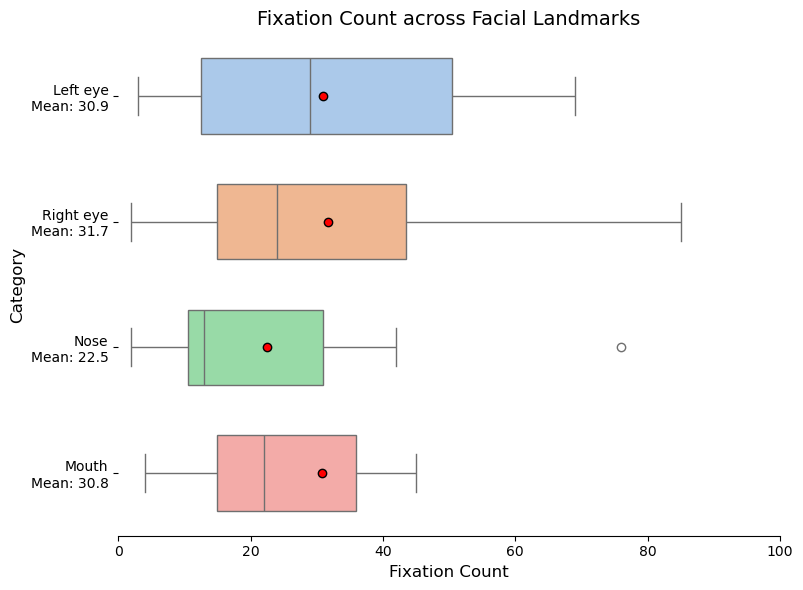

In [49]:
# Count fixations per AOI per Participant
fixation_counts = aoi_assignments_df.groupby(['Participant', 'assigned_aoi']).size().unstack(fill_value=0)

# Ensure columns of interest are present (left eye, right eye, nose, mouth)
fixation_cols = ['left_eye', 'right_eye', 'nose', 'mouth']

# Keep only those columns, fill missing columns with 0
fixation_counts = fixation_counts.reindex(columns=fixation_cols, fill_value=0)

# Reset index so 'Participant' is a column
fixation_counts = fixation_counts.reset_index()

# Melt to long format for seaborn
fixation_melted = fixation_counts.melt(
    id_vars=['Participant'],
    value_vars=fixation_cols,
    var_name='Category',
    value_name='Fixation Count'
)

# Capitalize category names nicely
fixation_melted['Category'] = fixation_melted['Category'].str.replace('_', ' ').str.capitalize()

# Define category order
category_order = fixation_melted['Category'].unique()

# Calculate means per category (optional, for labels)
group_means = fixation_melted.groupby('Category')['Fixation Count'].mean()
new_labels = [f"{cat}\nMean: {group_means[cat]:.1f}" for cat in category_order]

# Plot boxplot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=fixation_melted,
    y='Category',        # categories on y-axis
    x='Fixation Count',  # counts on x-axis
    order=category_order,
    palette='pastel',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

# Update y-axis labels to show means as before
ax.set_yticklabels(new_labels)

ax.set_title("Fixation Count across Facial Landmarks", fontsize=14)
ax.set_xlabel("Fixation Count", fontsize=12)
ax.set_ylabel("Category", fontsize=12)
sns.despine(left=True)
plt.tight_layout()
plt.xlim(0, 100)
plt.show()

In [50]:
# Calculate mean and std per Category
summary_stats = fixation_melted.groupby('Category')['Fixation Count'].agg(['mean', 'std']).round(2)

# Optional: rename columns for clarity
summary_stats = summary_stats.rename(columns={'mean': 'Mean Fixation Count', 'std': 'Standard Deviation'})

# Display the summary DataFrame
display(summary_stats)


,Mean Fixation Count,Standard Deviation
Category,,
Left eye,30.91,22.59
Mouth,30.82,26.94
Nose,22.55,22.12
Right eye,31.73,23.70


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_72405/1680219604.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_72405/1680219604.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


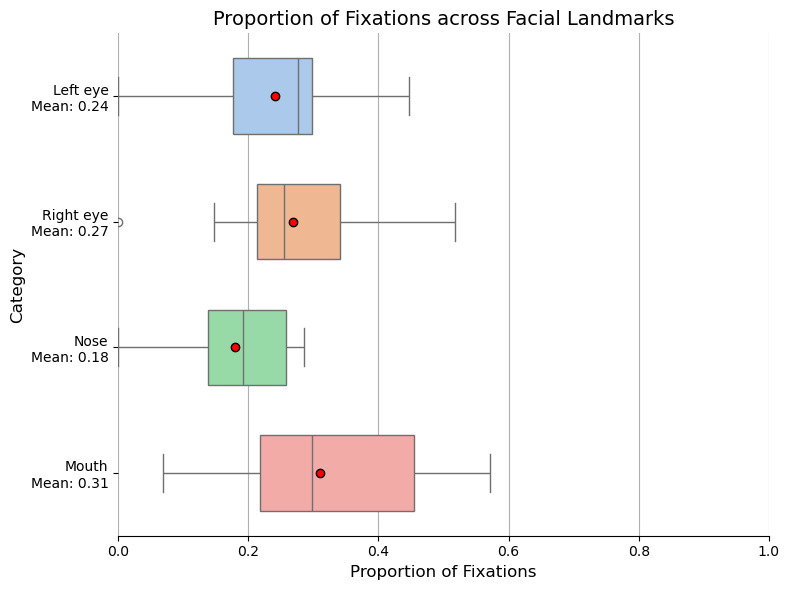

In [37]:
### proportions

# Count fixations per AOI per Participant
fixation_counts = aoi_assignments_df.groupby(['Participant', 'assigned_aoi']).size().unstack(fill_value=0)

# Ensure columns of interest are present (left_eye, right_eye, nose, mouth)
fixation_cols = ['left_eye', 'right_eye', 'nose', 'mouth']

# Keep only those columns, fill missing columns with 0
fixation_counts = fixation_counts.reindex(columns=fixation_cols, fill_value=0)

# Calculate proportion per participant (each row sum to 1)
fixation_props = fixation_counts.div(fixation_counts.sum(axis=1), axis=0)

# Reset index so 'Participant' is a column
fixation_props = fixation_props.reset_index()

# Melt to long format for seaborn
fixation_melted = fixation_props.melt(
    id_vars=['Participant'],
    value_vars=fixation_cols,
    var_name='Category',
    value_name='Proportion'
)

# Capitalize category names nicely
fixation_melted['Category'] = fixation_melted['Category'].str.replace('_', ' ').str.capitalize()

# Define category order
category_order = fixation_melted['Category'].unique()

# Calculate means per category (optional, for labels)
group_means = fixation_melted.groupby('Category')['Proportion'].mean()
new_labels = [f"{cat}\nMean: {group_means[cat]:.2f}" for cat in category_order]

# Plot horizontal boxplot of proportions
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=fixation_melted,
    y='Category',          # categories on y-axis
    x='Proportion',        # proportions on x-axis
    order=category_order,
    palette='pastel',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

# Update y-axis labels to show means
ax.set_yticklabels(new_labels)

ax.set_title("Proportion of Fixations across Facial Landmarks", fontsize=14)
ax.set_xlabel("Proportion of Fixations", fontsize=12)
ax.set_ylabel("Category", fontsize=12)
sns.despine(left=True)
ax.xaxis.grid(True)
plt.tight_layout()

# Optional: set x-axis limits 0 to 1 (proportions)
plt.xlim(0, 1)

plt.show()


In [30]:
print(fixation_melted['Category'].unique())

['Left eye' 'Right eye' 'Nose' 'Mouth']


# T-shape pattern + where the first same face fixation lands

In [ ]:
#  1. i need a df with assigned face Aois aoi_assignments_df + face bounding boxes to see if multiple fixations in a raw are actually on the same face
# 2. if there multiple fixations on the same face return and save the first and second fixation and check for eyes-nose-mouth pattern

In [ ]:
#for Fl - using fixation ids

base_path = "/Users/alina/Downloads/Thesis/raw"

aoi_types = ['right_eye', 'left_eye', 'nose', 'mouth']
aoi_index = {aoi: i for i, aoi in enumerate(aoi_types)}

def compute_duration_weighted_matrix(df):
    matrix = np.zeros((3, 3))
    df = df.sort_values(by=['participant', 'recording', 'fixation id']).reset_index(drop=True)

    for i in range(len(df) - 1):
        from_aoi = df.loc[i, 'type']
        to_aoi = df.loc[i + 1, 'type']

        # Make sure transitions are within the same participant and recording
        same_participant = df.loc[i, 'participant'] == df.loc[i + 1, 'participant']
        same_recording = df.loc[i, 'recording'] == df.loc[i + 1, 'recording']

        if same_participant and same_recording:
            weight = df.loc[i, 'duration [ms]']

            if from_aoi in aoi_index and to_aoi in aoi_index:
                matrix[aoi_index[from_aoi], aoi_index[to_aoi]] += weight
                #matrix[aoi_index[from_aoi], aoi_index[to_aoi]] += 1 # if no weights
    return matrix

def row_normalize(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        norm_matrix = np.divide(matrix, row_sums, where=row_sums != 0)
    return norm_matrix

def main():
    combined_records = []

    for participant_folder in os.listdir(base_path):
        if participant_folder.startswith("Participant"):
            participant_number = participant_folder.split()[-1]
            participant_id = f"P{participant_number}"
            folder_path = os.path.join(base_path, participant_folder)

            for recording_folder in os.listdir(folder_path):
                if recording_folder.startswith(f"P{participant_number}_"):
                    recording_number = recording_folder.split('_')[-1]
                    recording_path = os.path.join(folder_path, recording_folder)

                    try:
                        file_path = os.path.join(
                            recording_path, 
                            f"fixations_on_everything_{participant_number}_{recording_number}.csv"
                        )
                        df = pd.read_csv(file_path)
                        df['participant'] = participant_id
                        df['recording'] = recording_number
                        combined_records.append(df)

                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")

    combined_df = pd.concat(combined_records, ignore_index=True)

    matrix = compute_duration_weighted_matrix(combined_df)
    
    norm_matrix = row_normalize(matrix)

    print("Combined duration-weighted AOI transition matrix (row-normalized):\n", norm_matrix)

    # Optional: flatten matrix to feature vector
    feature_vector = norm_matrix.flatten()
    print("\nFlattened feature vector:\n", feature_vector)

    # Save combined matrix to CSV
    df_matrix = pd.DataFrame(norm_matrix, index=aoi_types, columns=aoi_types)
    df_matrix.to_csv("combined_transition_matrix.csv")

    def plot_transition_matrix(matrix, aoi_types, title="Transition Matrix"):
        df_plot = pd.DataFrame(matrix, index=aoi_types, columns=aoi_types)
        plt.figure(figsize=(6,5))
        sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Blues", cbar=True)
        plt.title(title)
        plt.xlabel("To AOI")
        plt.ylabel("From AOI")
        plt.show()

    plot_transition_matrix(matrix, aoi_types, title="Transition Matrix (Counts)")

    plot_transition_matrix(norm_matrix, aoi_types, title="Transition Matrix (Probability)")

if __name__ == "__main__":
    main()



